In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import cv2
from resolve_symbols import create_merged_boxes, determine_box_level, merge_dots, sub_or_superscript_level, isolate_symbols_and_square
import matplotlib.patches as patches
import cv2
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def resolve_symbols_on_img(img_file):
    """
    Given an input image file, use opencv's findContours to find the contours related to mathematical symbols,
    and prepare them for model prediction and equation rendering.
    Returns:
        1) A list of square image arrays, ordered by how the symbol should appear in an equation
        2) a 'level list'. Symbols with the same level can be rendered left to right. A new level indicates some change
        3) a 'stack list'. True/false for each symbol depending on whether it's part of a stack or not
        4) a 'script level list'. To determine whether a symbol is a sub/superscript of the previous one. equal script levels means the symbol should be at equal line height
        5) ax of a plot displaying the image
    """
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    img_size = img.shape[0] * img.shape[1]

    alpha = 1.5  # Contrast
    beta = 50    # Brightness
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    bw_pixs = len(img[(img == 0) | (img == 255)]) / img_size
    if bw_pixs > 0.5:
        ret,thresh=cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)
    else:
        thresh  = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
        blur = cv2.GaussianBlur(thresh,(13,13),0)
        bt = 140
        ret,thresh=cv2.threshold(blur,bt, 255, cv2.THRESH_BINARY)

    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1])

    fig, ax = plt.subplots(figsize=(10, 8))

    ax.imshow(img, cmap='gray')

    box_list = []
    
    ctrs_list = []
    
    for i,c in enumerate(cnt[1:]):
        x1,y1,x2,y2= cv2.boundingRect(c)

        ctr_ar = cv2.contourArea(c, oriented=True)
        
        if x2*y2 > 2.4e-4 *img_size and ctr_ar > 0:
            box_list.append([x1, y1, x2+x1, y2+y1])
            ctrs_list.append(c)
    
    box_list, merged_box_list = create_merged_boxes(box_list, img.shape[0])

    tot_boxes = box_list + merged_box_list
    tot_boxes = [list(x) for x in set(tuple(x) for x in tot_boxes)]

    tot_boxes, box_levels, stacked_list = determine_box_level(tot_boxes)
    
    tot_boxes, stacked_list, box_levels = merge_dots(tot_boxes, stacked_list, box_levels, img.shape[0])

    script_level = 0 
    script_level_list = [0]
    for b, box in enumerate(tot_boxes[:-1]):
        script_add, score = sub_or_superscript_level(tot_boxes[b], box_levels[b], tot_boxes[b+1], box_levels[b+1])
        if script_add == -10:
            script_level = 0
        else:
            script_level += script_add
        script_level_list.append(script_level)

    colors = ['r', 'g', 'b', 'g']
    
    ind_symbols = []
    for i, box in enumerate(tot_boxes):
        x1 = box[0]
        y1 = box[1]
        x2 = box[2] - box[0]
        y2 = box[3] - box[1]
   
        if stacked_list[i] > 0:
            er = 'b'
        else:
            er = 'r'
            
        if script_level_list[i] != 0:
            er = 'g'
            
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor=er, facecolor='none')

        ax.add_patch(rect)
        ax.text(x1, y1, str(i))
        ind_symbols.append(thresh[y1:y1+y2,x1:x1+x2])
                
    ax.plot([], color='b', label='Stacked symbols')
    ax.plot([], color='r', label='Base level symbols')
    ax.plot([], color='g', label='Super/subscripts')

    ind_symbols, extend_list = isolate_symbols_and_square(tot_boxes, box_levels, ind_symbols)
    # print("Box levels: ", box_levels)
    # print("Stacked List: ", stacked_list)
    # print("Script Level List: ", script_level_list)
    # print("Extend List: ", extend_list)
    # print(ax)
    
    return ind_symbols, box_levels, stacked_list, script_level_list, extend_list, ax

class MathSymbolCNN(nn.Module):
    def __init__(self, num_classes):
        super(MathSymbolCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def predict_latex_expression(symbols, script_levels, stacked_list, model_path):
    """
    Predicts the LaTeX expression from the given symbols, script levels, and stacked list.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(model_path, map_location=device)
    idx_to_label = checkpoint['idx_to_label']

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    model = MathSymbolCNN(len(idx_to_label))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval() 
    model = model.to(device)

    predictions = []

    for symbol in symbols:
        symbol = symbol / 255.0 

        height, width = symbol.shape 
        max_dim = max(height, width) 

        pad_height = (max_dim - height) // 2  
        pad_width = (max_dim - width) // 2   

        pad_height_top = pad_height
        pad_height_bottom = max_dim - height - pad_height_top
        pad_width_left = pad_width
        pad_width_right = max_dim - width - pad_width_left

        padded_symbol = np.pad(
            symbol,
            pad_width=((pad_height_top, pad_height_bottom), (pad_width_left, pad_width_right)),
            mode='constant',
            constant_values=1
        )

        square_dim = padded_symbol.shape[0] 

        pad_size = int(0.2 * square_dim)

        final_padded_symbol = np.pad(
            padded_symbol,
            pad_width=((pad_size, pad_size), (pad_size, pad_size)), 
            mode='constant',
            constant_values=1
        )

        resized_symbol = cv2.resize(final_padded_symbol, (64, 64), interpolation=cv2.INTER_AREA)
        resized_symbol = (resized_symbol * 255).astype(np.uint8) 
        
        transformed_symbol = transform(resized_symbol).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(transformed_symbol)
            _, predicted = torch.max(outputs, 1)
            predicted_idx = predicted.item()

        predictions.append(" " + idx_to_label[predicted_idx] + " ")

    latex_expr = ""
    group_buffer = "" 
    current_script_level = 0 

    in_fraction = False
    numerator_buffer = ""
    denominator_buffer = ""

    numerator_script_buffer = ""
    denominator_script_buffer = ""

    for i, symbol in enumerate(predictions):
        if stacked_list[i] > 0:  # Part of a fraction
            if not in_fraction:
                if group_buffer:  # Flush sub/superscript buffer
                    if current_script_level == 1:
                        latex_expr += f"^{{{group_buffer}}}"
                    elif current_script_level == -1:
                        latex_expr += f"_{{{group_buffer}}}"
                    group_buffer = ""
                current_script_level = 0
                in_fraction = True

            if stacked_list[i] == 1:  # Numerator
                if script_levels[i] == current_script_level:
                    numerator_buffer += symbol
                else:
                    if current_script_level != 0 and numerator_script_buffer:
                        if current_script_level == 1:
                            numerator_buffer += f"^{{{numerator_script_buffer}}}"
                        elif current_script_level == -1:
                            numerator_buffer += f"_{{{numerator_script_buffer}}}"
                        numerator_script_buffer = ""

                    current_script_level = script_levels[i]

                    if current_script_level == 0:
                        numerator_buffer += symbol
                    else:
                        numerator_script_buffer = symbol

            elif stacked_list[i] == 3:  # Denominator
                if script_levels[i] == current_script_level:
                    denominator_buffer += symbol
                else:
                    if current_script_level != 0 and denominator_script_buffer:
                        if current_script_level == 1:
                            denominator_buffer += f"^{{{denominator_script_buffer}}}"
                        elif current_script_level == -1:
                            denominator_buffer += f"_{{{denominator_script_buffer}}}"
                        denominator_script_buffer = ""

                    current_script_level = script_levels[i]

                    if current_script_level == 0:
                        denominator_buffer += symbol
                    else:
                        denominator_script_buffer = symbol
        else:  # Not part of a fraction
            if in_fraction:
                # Finish the fraction
                if numerator_script_buffer:
                    if current_script_level == 1:
                        numerator_buffer += f"^{{{numerator_script_buffer}}}"
                    elif current_script_level == -1:
                        numerator_buffer += f"_{{{numerator_script_buffer}}}"

                if denominator_script_buffer:
                    if current_script_level == 1:
                        denominator_buffer += f"^{{{denominator_script_buffer}}}"
                    elif current_script_level == -1:
                        denominator_buffer += f"_{{{denominator_script_buffer}}}"

                latex_expr += f"\\frac{{{numerator_buffer}}}{{{denominator_buffer}}}"
                numerator_buffer = ""
                denominator_buffer = ""
                numerator_script_buffer = ""
                denominator_script_buffer = ""
                in_fraction = False

            if script_levels[i] == current_script_level:
                if current_script_level == 0:
                    latex_expr += symbol
                else:
                    group_buffer += symbol 
            else:
                if current_script_level != 0 and group_buffer:
                    if current_script_level == 1:
                        latex_expr += f"^{{{group_buffer}}}"
                    elif current_script_level == -1:
                        latex_expr += f"_{{{group_buffer}}}"
                    group_buffer = ""

                current_script_level = script_levels[i]

                if current_script_level == 0:
                    latex_expr += symbol
                else:
                    group_buffer = symbol 

    if in_fraction:
        # Finish the fraction if it wasn't completed
        if numerator_script_buffer:
            if current_script_level == 1:
                numerator_buffer += f"^{{{numerator_script_buffer}}}"
            elif current_script_level == -1:
                numerator_buffer += f"_{{{numerator_script_buffer}}}"

        if denominator_script_buffer:
            if current_script_level == 1:
                denominator_buffer += f"^{{{denominator_script_buffer}}}"
            elif current_script_level == -1:
                denominator_buffer += f"_{{{denominator_script_buffer}}}"

        latex_expr += f"\\frac{{{numerator_buffer}}}{{{denominator_buffer}}}"

    if group_buffer:
        if current_script_level == 1:
            latex_expr += f"^{{{group_buffer}}}"
        elif current_script_level == -1:
            latex_expr += f"_{{{group_buffer}}}"

    return latex_expr

Predicted LaTeX Expression: \frac{ 1  +  m  +  m ^{ 3 } +  1  8 }{ 7  +  8  m } =  3  7 


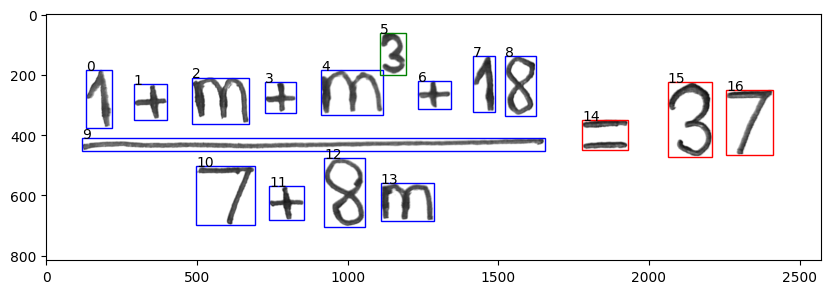

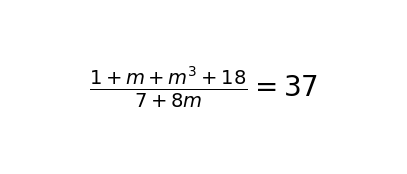

In [39]:
import re
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

if __name__ == "__main__":
    model_path = 'final_math_symbol_cnn.pth'
    
    symbols, _, stacked_list, script_levels, _, _ = resolve_symbols_on_img('num17.jpg')
    
    latex_expr = predict_latex_expression(symbols, script_levels, stacked_list, model_path)
    latex_expr = re.sub(r"\\frac(?!{)", "-", latex_expr)
    print("Predicted LaTeX Expression:", latex_expr)

    plt.figure(figsize=(5, 2))
    plt.text(0.5, 0.5, f"${latex_expr}$", fontsize=20, ha='center', va='center')
    plt.axis('off')
    plt.show()

In [ ]:
import sympy
from sympy import symbols, sympify, solve, Eq, simplify, N, E
import re

def latex_to_sympy(latex_expr):
    # Replace LaTeX fraction with sympy division
    latex_expr = re.sub(r'\\frac{(.*?)}{(.*?)}', r'(\1)/(\2)', latex_expr)
    
    # Replace LaTeX exponents with sympy exponents
    latex_expr = latex_expr.replace("^{", "**").replace("}", "")
    
    # Remove spaces
    latex_expr = latex_expr.replace(" ", "")
    
    # Add multiplication symbol between numbers and variables
    latex_expr = re.sub(r'(\d)([a-zA-Z])', r'\1*\2', latex_expr)
    
    # Replace 'e' with E (sympy's representation of e)
    latex_expr = re.sub(r'(?<![a-zA-Z])e(?![a-zA-Z])', 'E', latex_expr)

    # Replace '\pi' with pi (sympy's representation of pi)
    latex_expr = latex_expr.replace(r'\pi', 'pi')
    
    return latex_expr

def solve_or_evaluate(latex_expr):
    normalized_expr = latex_to_sympy(latex_expr)
    print("Normalized Expression:", normalized_expr)

    if "=" in normalized_expr:
        lhs, rhs = normalized_expr.split("=")
        lhs = lhs.strip()
        rhs = rhs.strip()
        
        # Create the equation
        equation = Eq(sympify(lhs), sympify(rhs))
        print("SymPy Expression:", equation)

        # Identify variables in the equation
        variables = list(set(sympy.Symbol(sym) for sym in re.findall(r'[a-zA-Z]+', normalized_expr) if sym not in ['E', 'pi']))

        if not variables:
            print("No variables found in the equation.")
            return

        # If there's only one variable, solve for it
        if len(variables) == 1:
            solutions = solve(equation, variables[0])
            numerical_solutions = [N(sol, 10) for sol in solutions]
            print(f"Solutions for {variables[0]}:", numerical_solutions)
        else:
            print("Multiple variables found:", variables)
            var_to_solve = input("Enter the variable to solve for: ")
            var_symbol = sympy.Symbol(var_to_solve)
            if var_symbol in variables:
                solutions = solve(equation, var_symbol)
                numerical_solutions = [N(sol, 10) for sol in solutions]
                print(f"Solutions for {var_symbol}:", numerical_solutions)
            else:
                print(f"Variable {var_to_solve} not found in the equation.")

        # Simplify the equation
        simplified_eq = simplify(equation)
        print("Simplified equation:", simplified_eq)

    else:
        # If it's just an expression, evaluate it
        expr = sympify(normalized_expr)
        simplified_expr = simplify(expr)
        print("Simplified expression:", simplified_expr)
        
        # Try to evaluate numerically
        try:
            numerical_value = N(simplified_expr, 10)
            print("Numerical value:", numerical_value)
        except:
            print("Unable to evaluate numerically. The expression may contain variables.")

# Example usage
# latex_expr = r'e ^{ 0.1 }'
solve_or_evaluate(latex_expr)


Normalized Expression: (1+m+m**3+18)/(7+8*m)=37
SymPy Expression: Eq((m**3 + m + 19)/(8*m + 7), 37)
Solutions for m: [-0.8153970678 + 0.e-14*I, -16.75334298 - 0.e-17*I, 17.56874004 - 0.e-15*I]
Simplified equation: Eq((m**3 + m + 19)/(8*m + 7), 37)
